# CS-EJ3211 Machine Learning with Python 

## Round 6 - Feature Learning

Machine learning applications often involve high-dimensional data. Consider data points represented by smartphone snapshots with a resolution of $1000 \times 1000$ pixels. If we stack the (red,green and blue) intensities of pixels into a vector, we obtain a vector of length at least $10^6$. 

In this round, we study dimensionality reduction methods that transform long feature vectors to shorter feature vectors which retain most of the relevant information contained in the raw long vectors. Such dimensionality reduction is useful for at least three reasons: 

1. Shorter feature vectors imply **less computations** required by subsequent ML methods. 
2. Shorter (but informative) feature vectors ensure **good generalization** of ML methods. Indeed, using very long feature vectors bears the risk of overfitting the training data. 
3. Transforming long raw vectors (e.g. obtained from pixel intensities of a snapshot obtained from a megapixel camera) to vectors of length 2 (or 3) allows to **visualize** data points in a [scatter plot](https://en.wikipedia.org/wiki/Scatter_plot).

This notebook discusses one of the most basic and widely used method for dimensionality reduction: principal component analysis (PCA). PCA amounts to computing a linear transformation of the original feature vector to few features ("principal components"). The principal components are those linear combinations of the original features that retain the maximum amount of information about the original feature vectors.

## Learning goals

After this round, you should 

- understand the basic idea behind dimensionality reduction. 
- be able to implement PCA using the Python library `scikit-learn`. 
- understand the trade-off between amount of dimensionality reduction and information loss. 
- be able to combine PCA with a supervised ML method such as linear regression. 

## Additional Material  
* [Video](https://www.youtube.com/watch?v=FgakZw6K1QQ) by StatQuest on PCA
* [Video lecture](https://www.youtube.com/watch?v=Zbr5hyJNGCs) of Prof. Andrew Ng on dimensionality reduction 
* [Video lecture](https://www.youtube.com/watch?v=cnCzY5M3txk) of Prof. Andrew Ng on dim. red. for data visualization 
* [Video lecture](https://www.youtube.com/watch?v=T-B8muDvzu0) of Prof. Andrew Ng on principal component analysis
* https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
* Chapter 9 of the [Course Book](https://arxiv.org/abs/1805.05052)  - Dimensionality Reduction.

## Bananas and Apples

<a id="data"></a>
Consider a dataset containing $m=30$ image files of apples and bananas: 

* 15 images of apples stored in the files named `1.jpg` to `15.jpg`
* 15 images of bananas stored in the files named `16.jpg` to `30.jpg`

The files contain color images, but for our purposes we convert them to grayscale images. We can represent each pixel of a grayscale image by a number between 0 (black pixel) and 255 (white pixel). The size of each images is $50\times50$ pixels. Thus, we can represent each fruit image by the "raw" feature vector $\mathbf{z} =\big(z_{1},\ldots,z_{J}\big)^{T} \in \mathbb{R}^{2500}$. The $j$th entry $z_{j}$ is the grayscale level of the $j$th pixel.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Loading the Data. 
   
    
The following code block loads the images, converts them into grayscale images and stores them in the matrix $\mathbf{Z} \in \mathbb{R}^{30 \times 2500}$ whose $i$th row $\mathbf{z}^{(i)} \in \mathbb{R}^{2500}$ contains the grayscale intensities for the $i$th image. The first three apple images and the first three banana images are displayed.

 </div>

In [1]:
# Import required libraries (packages) for this exercise
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')  # Change style for nice plots :)

The shape of the datamatrix Z is (30, 2500)


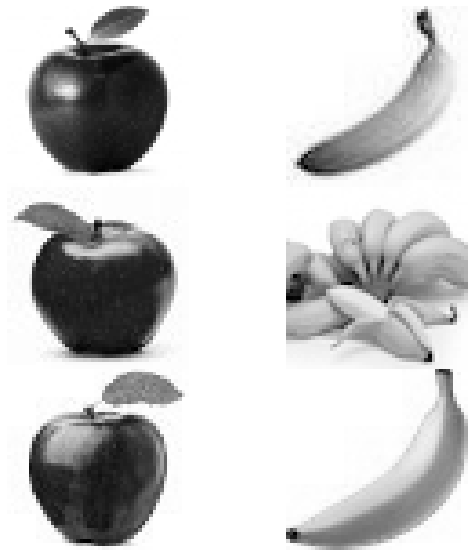

In [2]:
m = 30 # Number of images to include in dataset
dataset = np.zeros((m,50,50), dtype=np.uint8)   # create numpy array for images and fill with zeros 
D = 50*50  # length of raw feature vectors 

for i in range(1, m+1):
    # With convert('L') we convert the images to grayscale
    try:
        img = Image.open('/coursedata/fruits/%s.jpg'%(str(i))).convert('L') # Read in image from jpg file
    except:
        img = Image.open('../../data/fruits/%s.jpg'%(str(i))).convert('L') # Read if you are doing exercise locally
    dataset[i-1] = np.array(img, dtype=np.uint8)             # Convert image to numpy array with greyscale values
    
# Store raw image data in matrix Z
Z = dataset.reshape(m,-1)  # Reshape the 50 x 50 pixels into a long numpy array of shape (2500,1)
print("The shape of the datamatrix Z is", Z.shape) 

# Display first three apple images (fruits1.jpg,fruits2.jpg,fruits3.jpg) 
# and first three banana images (fruits16.jpg,fruits17.jpg,fruits18.jpg)
fig, ax = plt.subplots(3, 2, figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(3):
    for j in range(2):
        ax[i,j].imshow(dataset[i + (15*j)], cmap='gray')
        ax[i,j].axis('off')
plt.show()

## Principal Component Analysis
<a id="Q1"></a>

### Basic Idea of Linear Dimensionality Reduction 

Suppose we have at our disposal a dataset 

\begin{equation}
    \mathbf{Z} = \begin{bmatrix}
    z_1^{(1)} & z_2^{(1)} & \ldots & z_D^{(1)} \\
    z_1^{(2)} & z_2^{(2)} & \ldots & z_D^{(2)} \\
    \vdots & \vdots &\ddots & \vdots \\
    z_1^{(m)} & z_2^{(m)} & \ldots & z_D^{(m)}
    \end{bmatrix}\in \mathbb{R}^{m \times D},
\end{equation}

where $m$ is the number of datapoints and $D$ the number of features. The goal of dimensionality reduction is to transform the dataset $\mathbf{Z}$ into a lower dimensional dataset

\begin{equation}
    \mathbf{X} = \begin{bmatrix}
    x_1^{(1)} & x_2^{(1)} & \ldots & x_n^{(1)} \\
    x_1^{(2)} & x_2^{(2)} & \ldots & x_n^{(2)} \\
    \vdots & \vdots &\ddots & \vdots \\
    x_1^{(m)} & x_2^{(m)} & \ldots & x_n^{(m)}
    \end{bmatrix}\in \mathbb{R}^{m \times n},
\end{equation}

where $n < D$. As was mentioned in the introduction, the low-dimensional representation

- reduces the computational requirements of training an ML model on the dataset
- provides short but informative representations of the datapoints, which might improve generalization capability of an ML model
- makes it easier to visualize high-dimensional data.

In **linear dimensionality reduction** the datapoints $\mathbf{z}^{(i)}, i=1.\ldots,m$ are transformed to the corresponding low-dimensional representations  $\mathbf{x}^{(i)}$ with a linear transformation 

\begin{equation}
\begin{aligned}
    &\mathbf{x}^{(i)} =\mathbf{W} \mathbf{z}_c^{(i)}= \mathbf{W} \big( \mathbf{z}^{(i)} - \overline{\mathbf{z}}\big),&  \overline{\mathbf{z}} = (1/m) \sum_{i=1}^m \mathbf{z}^{(i)}.
\end{aligned}
\end{equation}

Here, the compression matrix $\mathbf{W} \in \mathbb{R}^{n \times D}$ maps the centered feature vectors $\mathbf{z}_c^{(i)} \in \mathbb{R}^D$ to their low-dimensional representations $\mathbf{x}^{(i)} \in \mathbb{R}^n$. Observe that the sample mean $\overline{\mathbf{z}}$ is subtracted from the datapoint $\mathbf{z}^{(i)}$ before performing the linear transformation with $\mathbf{W}$. This results in the transformed dataset $\mathbf{X}$ being centered at the origin.


### Optimal dimensionality reduction

The central objective in linear dimensionality reduction is to find the optimal compression matrix $\mathbf{W}$ **that results in the least amount of information loss** when transforming $\mathbf{Z}$ into is lower-dimensional representation $\mathbf{X}$. Let us assume that the rows of $\mathbf{W}$ are orthogonal unit vectors.

A natural measure of the information loss incurred by the transformation is the **reconstruction error**

\begin{equation}
\begin{aligned}
    \mathcal{E}(\mathbf{W}) &= (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} - \hat{\mathbf{z}}_c^{(i)} \|^{2} \\ &= (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} - \mathbf{W}^T \mathbf{x}^{(i)} \|^{2} \\ &= (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} - \mathbf{W}^T \mathbf{W} \mathbf{z}_c^{(i)} \|^{2}.
\end{aligned}
\end{equation}

Here, the centralized **reconstruction** $\hat{\mathbf{z}}_c^{(i)} \in \mathbb{R}^D$ of the datapoint $\mathbf{z}_c^{(i)}$ is obtained by the formula

\begin{equation}
\hat{\mathbf{z}}_c^{(i)} = \mathbf{W}^T \mathbf{x}^{(i)} = \mathbf{W}^T \mathbf{W}\mathbf{z}_c^{(i)}. 
\end{equation}

By multiplying the transformed datapoint $\mathbf{x}^{(i)}$ by $\mathbf{W}^T$ from the left, the transformed datapoints are defined in terms of the original features of the data (i.e. in terms of the coordinates in $\mathbb{R}^D$). This enables us to calculate the distance between the original and compressed datapoints in the original space $\mathbb{R}^D$, and hence also the reconstruction error. Furthermore, it can be shown that the matrix $\mathbf{W}^T\mathbf{W}$ is an [**orthogonal projection**](https://en.wikipedia.org/wiki/Projection_(linear_algebra)) matrix that (orthogonally) projects the datapoints $\mathbf{z}_c^{(i)}$ onto the subspace spanned by the rows of $\mathbf{W}$.

Note that the reconstruction error can be given equivalently in terms of the non-centralized datapoints $\mathbf{z}^{(i)}$ and reconstructions $\hat{\mathbf{z}}^{(i)}$:

\begin{equation}
\begin{aligned}
    \mathcal{E}(\mathbf{W}) &= (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} - \hat{\mathbf{z}}_c^{(i)} \|^{2} \\ &= (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} + \overline{\mathbf{z}} - \overline{\mathbf{z}} - \mathbf{z}_c^{(i)} \|^{2} \\ &= (1/m) \sum_{i=1}^{m} \| (\mathbf{z}_c^{(i)} + \overline{\mathbf{z}}) - (\hat{\mathbf{z}}_c^{(i)} + \overline{\mathbf{z}}) \|^{2} \\ & = (1/m) \sum_{i=1}^{m} \| \mathbf{z}^{(i)} - \hat{\mathbf{z}}^{(i)} \|^{2}.
\end{aligned}
\end{equation}

 More descriptively speaking, the reconstruction error gives the mean squared distance between the true datapoints $\mathbf{z}^{(i)}$ and the reconstructed datapoints $\hat{\mathbf{z}}^{(i)} = \mathbf{W}^T \mathbf{x}^{(i)} + \overline{\mathbf{z}}$. This is a very intuitive quantification of information loss - the less information is lost in the transformation to the lower dimenstional space, the closer the reconstruction $\hat{\mathbf{Z}}$ is to the true data $\mathbf{Z}$.

The fundamental result of **principal component analysis** (PCA) is that the reconstruction error is minimized when

\begin{equation}
    \mathbf{W} = \mathbf{W}_{\rm PCA} = \big(\mathbf{u}^{(1)}, \mathbf{u}^{(2)}, \ldots, \mathbf{u}^{(n)} \big)^T,
\end{equation}

where the rows $\mathbf{u}^{(i)}$ are the $n$ first **principal components** of $\mathbf{Z}$. The first principal component is chosen so that it corresponds to the direction in $\mathbb{R}^D$ along which the data $\mathbf{Z}$ exhibits the most variance. The subsequent components are chosen so that the $i$:th component corresponds to the direction that exhibits the most variance, **while being orthogonal** to the components $1 \leq j < i$.

When we use PCA to transform the datapoints in $\mathbf{Z}$ to the lower dimensional space $\mathbb{R}^n$ (where each datapoint has $n$ features) we say that we perform PCA with $n$ components. An important consequence of the definition of $\mathbf{W}_{\rm PCA}$ is that the order of the rows in $\mathbf{W}_{\rm PCA}$ is the same, regardless of the amount of components used in the transformation. Given two PCA matrices $\mathbf{W}_n$ and $\mathbf{W}_k$ with $n$ and $k < n$ components respectively, the k first components in $\mathbf{W}_n$ will be identical to the ones in $\mathbf{W}_k$.

### Example: PCA in 2d with one component

The image below visualizes principle component analysis in 2-d, and shows the datapoints along with the first - and in this case the only  - principal component. When the dataset is transformed into a lower dimensional representation, the data points are transformed onto the subspace spanned by the principal component as shown by the red lines.

<img src="pca.png" alt="Drawing" style="width: 600px;"/>

In this case, the transformed data is one-dimensional and each datapoint will only be characterized by its value along the axis spanned by the 1st principal component. Even though this is not shown in the image, it is easy to imagine the green line being the sole axis and the datapoints being located on that 1-d axis at the points indicated by the red lines.

When the data is reconstructed the resulting data points $\hat{\mathbf{z}}^{(i)}$ will be located on the 1st principal component in 2-d space as shown in the image. As such, the red lines represent the difference between the original and reconstructed datapoints, and the reconstruction error corresponds to the mean of the squared lengths of these lines.

Based on the image, it should be quite easy to believe that the principal component in fact minimizes the reconstruction error. If we would move or rotate the green component, the total squared distances would inevitably get larger. We can also verify that this component also corresponds to the direction of largest variance in the data. 

### Transforming entire datasets

So far in this notebook, the transformation formulas have been of the form used to transform one datapoint at a time. In practice, we typically want to compress or reconstruct the entire dataset at once. The compression of the entire dataset $\mathbf{Z}$ is done by the transform

\begin{equation}
\mathbf{X} = \mathbf{Z}_c\mathbf{W}_{\rm PCA}^T = \big(\mathbf{Z} - \overline{\mathbf{Z}}\big) \mathbf{W}_{\rm PCA}^T,
\end{equation}

where $\overline{\mathbf{Z}}$ is a matrix with the sample mean vector in every row.

In order to understand why this transform works, first recall that the individual datapoints in the matrices $\mathbf{Z}$ and $\mathbf{X}$ are stacked row-wise. By standard matrix multiplication we get that the $i$:th row in $\mathbf{X}$ corresponding to the $i$:th compressed datapoint is given as

\begin{equation}
    {\mathbf{x}^{(i)}}^T = {\mathbf{z}_c^{(i)}}^T \mathbf{W}_{\rm PCA}^T,
\end{equation}

which is clearly just the transposed equivalent of 

\begin{equation}
    {\mathbf{x}^{(i)}} = \mathbf{W}_{\rm PCA} {\mathbf{z}_c^{(i)}}.
\end{equation}

Hence we can use the matrix multiplication defined above to compress the dataset instead of compressing each individual datapoint separately. By similar arguments we find that the formula for the reconstructed data is

\begin{equation}
 \hat{\mathbf{Z}} = \mathbf{X}\mathbf{W}_{\rm PCA} + \overline{\mathbf{Z}}.
\end{equation}

If you are not completely convinced by this, it is a good exercise to verify that the rows of the $\hat{\mathbf{Z}}$ contain the reconstructed datapoints!

**General note:** In this section we have defined $\mathbf{W}_{\rm PCA}$ such that the principal components are in the rows of the matrix. In contrast, some sources define the matrix such that the components are in the columns. If you consult other resources and find seemingly different transformation formulas, be sure to check the definition of the matrix in order to avoid unnecessary confusion!

## PCA Off-The-Shelf in Python

<img src="transforms.png" alt="transforms" />

The Python library `scikit-learn` provides the class `PCA`. This class provides methods to compute the optimal compression matrix $\mathbf{W}_{\rm PCA}$ of the data $\mathbf{Z}$, as well as methods with which to perform PCA transformations and reconstructions. The image above shows how the methods of the `PCA` object correspond to the transformations presented in this notebook. Below, we give a brief description of the most important methods in the class.

- `PCA.fit(Z)` calculates $\mathbf{W}_{\rm PCA}$ and stores it in the attribute `PCA.components_`. Note that the data matrix `Z` should be uncentered, since the `PCA` class stores the sample mean of the data that is used when transforming and   reconstructing data with the fitted `PCA` object.

- `PCA.transform(Z)` performs PCA transformation on `Z` in order to get the lower dimensional representation `X` of the data. Observe that the function performs the centralization of `Z` "under the hood", and as such the resulting compression is of the form $\mathbf{X} = \mathbf{Z}_c\mathbf{W}^T$.

- `PCA.inverse_transform(X)` performs the inverse operation to `PCA.transform(Z)`, that is, it takes as input the PCA transformed data `X` and returns a reconstrution `Z_hat` with the same dimensionality as the original data `Z`. Mathematically, the reconstruction is of the form $\hat{\mathbf{Z}} = \mathbf{XW} + \overline{\mathbf{Z}}$, where each row of $\overline{\mathbf{Z}}$ is the sample mean.

<a id='ImplementPCA'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b> Compute PCA. <br/>

Apply PCA to the data matrix $\mathbf{Z}$ obtained from the fruit images. In particular, compute the optimal compression matrix `W_pca` for the specified number $n$ of PCs (the value of n is set in the code snippet below). 
The compression matrix should be stored in the numpy array `W_pca` of shape $(n,2500)$. Also, compute the corresponding reconstruction error
\begin{equation}
(1/m) \sum_{i=1}^{m} \big\| \mathbf{z}^{(i)} - \hat{\mathbf{z}}^{(i)} \big\|^{2}_{2}= 
(1/m) \sum_{i=1}^{m} \big\| \mathbf{z}^{(i)} - \mathbf{W}_{\rm PCA}^{T} \mathbf{W}_{\rm PCA} \mathbf{z}^{(i)} \big\|^{2}_{2} 
\end{equation} 

You should store the reconstruction error in variable `err_pca`. 
    
Hints: 
- Use the Python class `PCA` from the library `sklearn.decomposition` to compute the optimal compression matrix $\mathbf{W}_{\rm PCA}$ for the feature vectors (representing fruit images) in the rows of `Z`.
- Use the functions described above to calculate the reconstruction `Z_hat`.
- Finally, use the resulting `Z_hat` to calculate the reconstruction error according to the formula above.The easiest way to calculate the error might be to expand the formula for the reconstruction error above, and try to understand how this formula could be obtained using the elements of the matrix subtraction `Z - Z_hat`.
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
 

</div>

In [5]:
from sklearn.decomposition import PCA

n = 10  # Define the number of principal components

### STUDENT TASK ###
### BEGIN SOLUTION
pca = PCA(n_components = n)  # create the object
pca.fit(Z)  # compute optimal transform W_PCA
W_pca = pca.components_
X = pca.transform(Z)
Z_hat = pca.inverse_transform(X)
err_pca = np.mean((Z-Z_hat)**2)*D
### END SOLUTION 

print(f'Shape of Z: {Z.shape}')
print(f'Shape of compression matrix W: {W_pca.shape}')
print(f'Reconstruction error: {err_pca}')

Shape of Z: (30, 2500)
Shape of compression matrix W: (10, 2500)
Reconstruction error: 925712.0873160226


In [4]:
# Perform sanity checks on the results
assert W_pca.shape == (n, Z.shape[1]), "Output matrix (W_pca) dimensions are wrong."
assert err_pca <= 1e6, "The reconstruction error is too high."

print('Sanity checks passed!')

### BEGIN HIDDEN TESTS
t_pca = PCA(n_components = n) # create the object
t_pca.fit(Z)     # compute optimal transform W_PCA
t_W_pca = t_pca.components_
t_X = t_pca.transform(Z)
t_Z_hat = t_pca.inverse_transform(t_X)
t_err_pca = np.mean((Z-t_Z_hat)**2)*D

np.testing.assert_allclose(W_pca.reshape(1,-1), t_W_pca.reshape(1,-1), atol=0.01, err_msg='W_pca is not the desired solution.')
np.testing.assert_allclose(err_pca, t_err_pca, rtol=0.001, err_msg='err_pca has wrong value')
### END HIDDEN TESTS

Sanity checks passed!


## Interpretation of the compressed data and compression matrix

While we know that the features of the original dataset $\mathbf{Z}$ represents the intensities at each pixel, we have not considered how the compression matrix and compressed data can be interpreted. As was shown in the example earlier in the notebook, **each principle component $\mathbf{u}^{(i)}$ stored in the rows of $\mathbf{W}_{\rm PCA}$ corresponds to a direction in the space that is spanned by the features of $\mathbf{Z}$**. With the image data used in this notebook, these directions correspond to a vector of pixel values and can be represented as an image.

By multiplying the centralized feature vector $\mathbf{z}_c$ with the compression matrix $\mathbf{W}_{\rm PCA}$, we get the compressed vector $\mathbf{x}$ in which each element $x_i$ represents the position of the centralized datapoint $\mathbf{z}_c$ along the $i$:th principle component. In essence, **the values of the elements $x_i$ quantify the amount of the principle component $\mathbf{u}^{(i)}$ present in the datapoint $\mathbf{z}_c$**. With this in mind, it is very intuitive that the centralized reconstruction $\hat{\mathbf{z}}_c$ is given by the linear combination 

\begin{equation}
\hat{\mathbf{z}}_c = \mathbf{W}_{\rm PCA}^T \mathbf{x} = \left[ \mathbf{u}^{(1)}, \mathbf{u}^{(2)}, \ldots, \mathbf{u}^{(n)}\right] \mathbf{x} = \sum_{i=1}^n \mathbf{u}^{(i)}x_i
\end{equation}

of the principle components $\mathbf{u}^{(i)}$ in the rows of $\mathbf{W}_{\rm PCA}$ (and the columns of the transpose). In the case of the image data, this means that each image can be given as a linear combination of images corresponding to the principle components.



<a id='reconstructionerror'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Principal Directions. <br/> 
    
Keeping the above in mind, it is instructive to examine the principle components $\mathbf{u}^{(1)},\mathbf{u}^{(2)}...,\mathbf{u}^{(n)}$ in the rows of optimal compression matrix $\mathbf{W}_{\rm PCA}$. Since each successive principle components explains a decreasing amount of variance in the original data, it is especially interesting to examine the first principle components as they explain the largest amount of variance.

The code snippet below plots the five first principal directions.
</div>

In [1]:
def plot_princ_comp(W_pca):
    fig, ax = plt.subplots(1, 5, figsize=(15,15))
    # Select the PCs we are plotting
    # You can change these to see what other components look like
    plot_pd = [0,1,2,3,4]

    for i in range(len(plot_pd)):
        ax[i].imshow(np.reshape(W_pca[plot_pd[i]], (50,50)), cmap='gray')
        ax[i].set_title("Principal Direction %d"%(plot_pd[i] + 1))
        ax[i].set_axis_off()  # Remove x- and y-axis from each image
    plt.show()

plot_princ_comp(W_pca)

NameError: name 'W_pca' is not defined

Now we can try interpret the meaning of the principle directions from the images above. For example, the principle direction 1 seems to correspond to the level of some kind of "appleness" of the image, whereas the third direction seems to capture some kind of "banananess". Doing this kind of interpretation can help us in obtaining insight of a dataset by finding meaning in the directions of the largest variance. 

## Trading Compression Against Information Loss
<a id="Q2"></a>

Next, we study the effect of using different numbers $n$ of PCs for the new feature vector $\mathbf{x}$. In particular, we will examine whether there is a trade-off between amount of compression (larger for smaller $n$) and the amount of information loss, which is quantified by the reconstruction error.

<a id='reconstructionerror'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Reconstruction Error vs. Number of PCs. <br/> </p>
    
Use the fruit image data `Z` and analyze how the reconstruction error of PCA changes with the number of PCs n used. In particular, apply PCA to the dataset `Z` for varying number of PCs $n=1,\ldots,m$. For each choice for $n$, compute the corresponding reconstruction error and store it in the numpy array `err_pca` of shape (m, ).

    
    
Hints:
    
For each number $n$ of PCs:
    
- Compute the compressed dataset $\mathbf{X}$.
    
- Use $\mathbf{X}$ to compute the optimal reconstruction $\widehat{\mathbf{Z}}$.
    
- Use $\widehat{\mathbf{Z}}$ to compute the reconstruction error $(1/m) \sum_{i=1}^{m} \big\| \mathbf{z}^{(i)} - \widehat{\mathbf{z}}^{(i)}\big\|^{2}$.
    
- Store the reconstruction error in the numpy array `err_pca`. The first entry should be the reconstruction error obtained for $n=1$.

</div>

Reconstruction errors for n=20,...,25: 
 [198577.55080093 161534.58198062 128996.01081947  99121.75285675
  72602.96102213  48886.13055594]


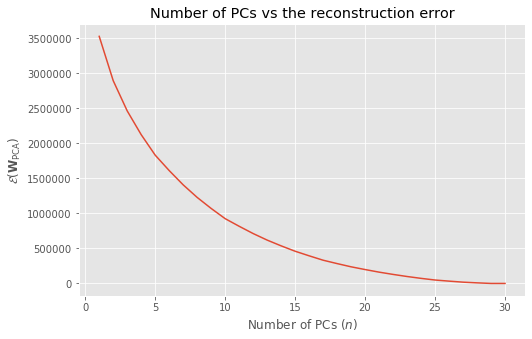

In [11]:
err_pca = np.zeros(m)  # Array for storing the PCA errors

for n_minus_1 in range(m):
    ### STUDENT TASK ### 
    # Compute the reconstruction error for PCA using n PCs and store it in err_pca[n-1]
    ### BEGIN SOLUTION
    pca = PCA(n_components=(n_minus_1+1)) 
    pca.fit(Z)
    W_pca = pca.components_
    X = pca.transform(Z)
    Z_hat = pca.inverse_transform(X)
    err_pca[n_minus_1] = np.sum(np.square(Z - Z_hat))/Z.shape[0]
    ### END SOLUTION

# Print reconstruction errors n=20,...,25 for quiz question
print(f"Reconstruction errors for n=20,...,25: \n {err_pca[19:25]}")
    
# Plot the number of PCs vs the reconstruction error
plt.figure(figsize=(8,5))
plt.plot([i + 1 for i in range(m)], err_pca)
plt.xlabel('Number of PCs ($n$)')
plt.ylabel(r'$\mathcal{E}(\mathbf{W}_{\rm PCA})$')
plt.title('Number of PCs vs the reconstruction error')
plt.show()  

In [7]:
# Perform some sanity checks on the outputs
assert err_pca.shape == (m, ), "shape of err_pca is wrong."
assert err_pca[0] > err_pca[m-1], "values of err_pca are incorrect"
assert err_pca[0] > err_pca[1], "values of err_pca are incorrect"

print('Sanity checks passed!')

### BEGIN HIDDEN TESTS
t_err_pca = np.zeros(m)
for n_minus_1 in range(m):
    t_pca = PCA(n_components=(n_minus_1+1)) 
    t_pca.fit(Z)
    t_W_pca = t_pca.components_
    t_X = t_pca.transform(Z)
    t_Z_hat = t_pca.inverse_transform(t_X)
    t_err_pca[n_minus_1] = np.sum(np.square(Z - t_Z_hat))/Z.shape[0]

np.testing.assert_allclose(err_pca.reshape(1,-1), t_err_pca.reshape(1,-1), rtol=0.1, err_msg='err_pca has wrong value')
### END HIDDEN TESTS

Sanity checks passed!


If the task is solved correctly, we can see that the reconstruction error decreases quite smoothly with an increasing number of components. 

## Choosing the number of components in PCA

An important decision that has to be made when applying PCA is the choice of the number of components $n$. The correct choice of $n$ is highly specific to the application, and there is no hard rule based on which to choose an objectively correct value. 

A simple but common approach for choosing $n$ is to choose a threshold proportion of total variance explained (e.g. 0.8 or 0.9), and select the smallest number of components such that their cumulative explained variance exceeds the threshold. By using this approach, we are effectively choosing an upper bound for the tolerated information loss.

<a id='explainedvariance'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Proportion of variance explained. <br/> </p>
    
Use the fruit image data `Z` and `PCA` to find the minimum number of components $n$ such that the cumulative proportion of explained variance of the $n$ first components exceeds $0.9$. 
    
You are required to store 
    
- an $(n_{\rm max}, )$ array containing the **proportions of total variance explained** by each of the individual components in the variable `var_ratio`, 
- an $(n_{\rm max}, )$ array containing the **cumulative proportion of total variance explained** in the variable `cum_var_ratio`,  
- the minimum number of components whose cumulative proportion of explained variance exceeds `threshold` in the variable `n_threshold`

  
**Hints**:
    
- Fit a PCA model with `n_max` components.
    
- The proportions of total variance explained by each component can be found in the attribute `PCA.explained_variance_ratio_`.
    
- `np.cumsum()` is convenient for calculating the cumulative proportions of total variance explained.
    
- `np.where(condition)` can be a useful tool for finding `n_threshold`.
</div>

Number of components selected: 11
Proportion of variance explained: 0.9055512581090452


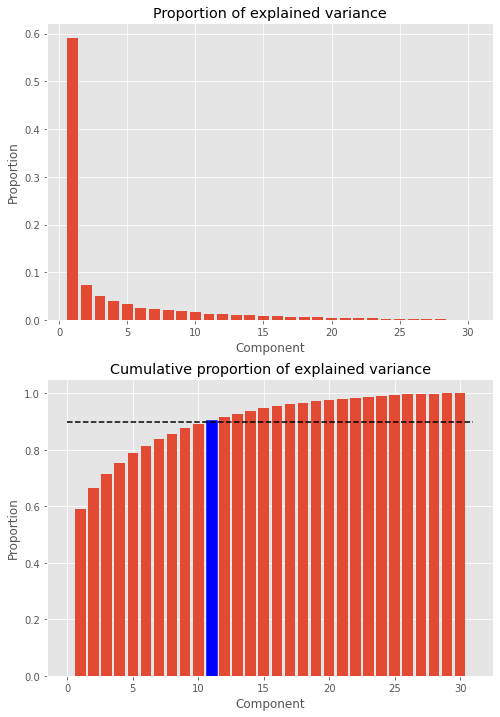

In [8]:
n_max = m    # Maximum amount of components
threshold = 0.9    # Threshold for selecting the number of components
### STUDENT TASK ###
# ...
# var_ratio = ...
# cum_var_ratio = ...
# n_threshold = ...
### BEGIN SOLUTION
pca = PCA(n_components=n_max)
pca.fit(Z)
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)
n_threshold = np.where(cum_var_ratio >= threshold)[0][0] + 1
### END SOLUTION
 
print(f"Number of components selected: {n_threshold}")
print(f"Proportion of variance explained: {cum_var_ratio[n_threshold-1]}")

# Plot the number of PCs vs the reconstruction error
fig, ax = plt.subplots(2, 1, figsize=(8,12))
x_bar = range(1, n_max+1)
ax[0].bar(x_bar, var_ratio)
ax[0].set_title("Proportion of explained variance")
ax[0].set_xlabel("Component")
ax[0].set_ylabel("Proportion")
barlist = ax[1].bar(x_bar, cum_var_ratio)
barlist[n_threshold-1].set_color('b')
ax[1].plot([0,31], [0.9, 0.9], '--', color='black')
ax[1].set_title("Cumulative proportion of explained variance")
ax[1].set_xlabel("Component")
ax[1].set_ylabel("Proportion")
plt.show()  

In [9]:
# Perform some sanity checks on the outputs
assert var_ratio.shape == (30,), "var_ratio is of the wrong shape!"
assert cum_var_ratio.shape == (30,), "cum_var_ratio is of the wrong shape!"
assert n_threshold in range(10, 20), "n_threshold is too low or too high!"

### BEGIN HIDDEN TESTS
t_pca = PCA(n_components=n_max)
t_pca.fit(Z)
t_var_ratio = pca.explained_variance_ratio_
t_cum_var_ratio = np.cumsum(t_var_ratio)
t_n_threshold = np.where(t_cum_var_ratio >= threshold)[0][0] + 1

np.testing.assert_allclose(var_ratio.reshape(1,-1), t_var_ratio.reshape(1,-1), rtol=0.1, err_msg='var_ratio has wrong value')
np.testing.assert_allclose(cum_var_ratio.reshape(1,-1), t_cum_var_ratio.reshape(1,-1), rtol=0.1, err_msg='cum_var_ratio has wrong value')
assert n_threshold == t_n_threshold, "n_threshold is incorrect!"
### END HIDDEN TESTS

Next, we will examine how increasing the number of components in the PCA transformation affects the quality of the reconstructions in practice. Will we be able to see the decrease in reconstruction error with our own eyes in the case of the fruit images?

In the demo below, we will plot reconstructed images for PCA compressions with a different number of components. By relying on intuition and the results above, we should expect that a larger number of components results in a reconstruction that is closer to the original image.

<a id='reconstructionerror'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Reconstructions. <br/> 
    
The code snippet below shows the reconstructions $\widehat{\mathbf{z}}^{(i)} = \mathbf{W}_{\rm PCA}^{T} \mathbf{x}^{(i)} + \overline{\mathbf{z}}$ for the number of PCs $n=1,5,10,20,30$. 

In the code, the `PCA` class is only used to obtain the compression matrix $\mathbf{W}_{\rm PCA}$. The PCA transformation and reconstruction are then done by matrix operations.
</div>

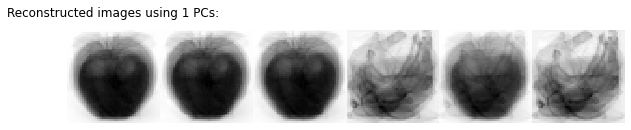

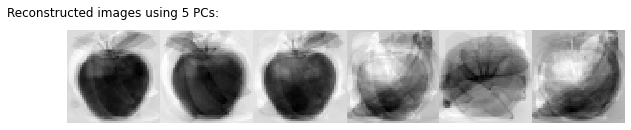

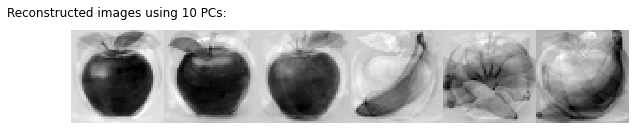

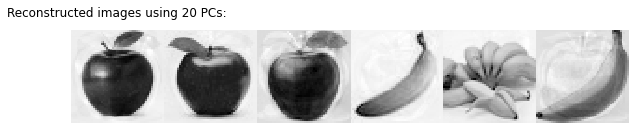

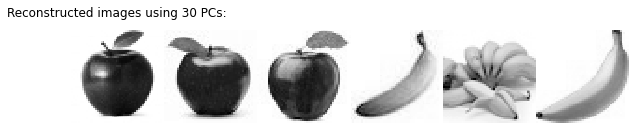

In [10]:
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

## Input:
#  Z: Dataset
#  n: number of dimensions
#  m_pics: number of pics per class (Apple, Banana). Min 1, Max 15
def plot_reconstruct(Z, W_pca, n, m_pics=3):

    # Center Z
    Z_centered = Z - np.mean(Z, axis=0)
    # x=w*z
    X_pca = np.matmul(W_pca[:n,:], Z_centered[:,:,None])
    # x_reversed=r*x + mean(z)
    Z_hat = np.matmul(W_pca[:n,:].T, X_pca)[:,:,0] + np.mean(Z, axis=0)
    
    # Setup figure size that scales with number of images
    fig = plt.figure(figsize = (10,10))
    
    # Setup a (n_pics,2) grid of plots (images)
    gs = gridspec.GridSpec(1, 2*m_pics)
    gs.update(wspace=0.0, hspace=0.0)
    for i in range(m_pics):
        for j in range(0,2):
            # Add a new subplot
            ax = plt.subplot(gs[0, i+j*m_pics])
            # Insert image data into the subplot
            ax.imshow(np.reshape(Z_hat[i+(15*j)], (50,50)), cmap='gray', interpolation='nearest')
            # Remove x- and y-axis from each plot
            ax.set_axis_off()
    
    plt.subplot(gs[0,0]).set_title("Reconstructed images using %d PCs:"%(n), size='large', y=1.08)
    plt.show()
    
pca = PCA(n_components=m) # create the object
pca.fit(Z)    # compute optimal transform W_PCA
W_pca = pca.components_
    
# The values of PCS n to plot for. You can change these to experiment
num_com = [1, 5, 10, 20, 30]
for n in num_com:
    # If you want to print different amount of pictures, you can change the value of m_pics. (1-15)
    plot_reconstruct(Z, W_pca, n, m_pics=3)

Observing the reconstructed images, one can clearly see that the reconstructions improve with an increasing number of principal components. This is in line with the decreasing reconstruction error seen in the student task "Reconstruction Error vs. Number of PC".

## PCA for Data Visualization
<a id="Q3"></a>

An important application of PCA is data visualization. By using PCA to reduce the dimensionality of higher dimensional data to two or three dimensions, it is possible to visualize high dimensional data along those directions in which the data exhibits the largest variance. 

For example, when using PCA with $n=2$ PCs, the resulting feature vectors $\mathbf{x}^{(1)} = \mathbf{W}_{\rm PCA} \mathbf{z}_c^{(1)}, \ldots, \mathbf{x}^{(m)} = \mathbf{W}_{\rm PCA} \mathbf{z}_c^{(m)} \in \mathbb{R}^{2}$ can be visualized in a two-dimensional scatterplot whose x-axis represents the first PC $x_{1}^{(i)}$ and y-axis the second PC $x_{2}^{(i)}$.

<a id='dataprojection'></a>
<div class=" alert alert-warning">
    <b>Student task.</b> Scatter Plots using Two PCs.   <br/> 

The following code visualizes the data as a scatter plot using either the first two PCs $x_{1}$, $x_{2}$ or using the 8th and 9th PCs $x_{8}$ and $x_{9}$. Your task is to fit the PCA model, transform the data `Z` to the lower dimensional transformation `X`, and store the 1st and 2nd, and the 8th and 9th PCs in the variables `X_PC12` and `X_PC89` respectively. Once again, remember that the indexing starts from 0 in Python!
    
The rest of the code plots two scatterplots using the selected pairs of features.

</div>

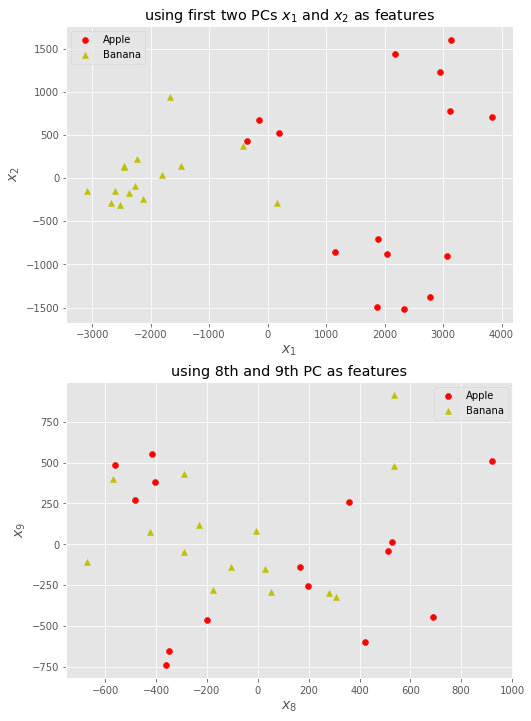

In [11]:
### STUDENT TASK ###
# Fit PCA with m components
# .
# .
# .
# X_PC12 = X[:,...]
# X_PC89 = X[:,...]
### BEGIN SOLUTION
pca = PCA(n_components=m)
pca.fit(Z)
X = pca.transform(Z)
X_PC12 = X[:,[0,1]]  # Choose the principle components 1 and 2
X_PC89 = X[:,[7,8]]  # Choose principle components 8 and 9
### END SOLUTION

plt.rc('axes', labelsize=14)    # Set fontsize of the x and y labels
 
fig, ax = plt.subplots(2, 1, figsize=(8,12))  # Create two subplots

# Scatterplot of the compressed data w.r.t PCs 1 and 2
ax[0].scatter(X_PC12[:15,0], X_PC12[:15,1], c='r',marker='o', label='Apple')
ax[0].scatter(X_PC12[15:,0], X_PC12[15:,1], c='y', marker='^', label='Banana')
ax[0].set_title('using first two PCs $x_{1}$ and $x_{2}$ as features')
ax[0].legend()
ax[0].set_xlabel('$x_{1}$')
ax[0].set_ylabel('$x_{2}$')
    
# Scatterplot of the compressed data w.r.t PCs 7 and 8
ax[1].scatter(X_PC89[:15,0], X_PC89[:15,1], c='r', marker='o', label='Apple')
ax[1].set_title('using 8th and 9th PC as features')
ax[1].scatter(X_PC89[15:,0], X_PC89[15:,1], c='y', marker='^', label='Banana')
ax[1].legend()
ax[1].set_xlabel('$x_{8}$')
ax[1].set_ylabel('$x_{9}$')

plt.show()

In [12]:
# Perform some sanity checks on the results
assert X_PC12.shape == (30,2), f"X_PC12 is of the wrong shape!"
assert X_PC89.shape == (30,2), f"X_PC12 is of the wrong shape!"

print("Sanity checks passed!")

### BEGIN HIDDEN TESTS
pca_t = PCA(n_components=m)
pca_t.fit(Z)

X_t = pca.transform(Z)

X_PC12_t = X_t[:,[0,1]]  # Choose the principle components 1 and 2
X_PC89_t = X_t[:,[7,8]]  # Choose principle components 8 and 9

np.testing.assert_allclose(X_PC12, X_PC12_t, rtol=0.1, err_msg='X_PCA12 has wrong value')
np.testing.assert_allclose(X_PC89, X_PC89_t, rtol=0.1, err_msg='X_PCA89 has wrong value')
### END HIDDEN TESTS

Sanity checks passed!


From the plots above, it is easy to confirm that the data exhibits the largest variance along the first principal component, with successive components explaining a decreasing amount of variance.

By visualizing the data with respect to the first  principle components, we can obtain insights of the data. For example, the first scatterplot seems to indicate that the images containing apples and bananas can be separated quite well using the first principle component. This coincides with what we inferred earlier in the notebook - that the first principle component corresponds to some kind of "appleness" of the image.

It is hardly surprising that we could find this kind of separation in the case of the fruit image dataset, so it can seem that the scatterplot is not tremendously useful. However, on other datasets one might find less obvious relationships with respect to some principal components that might provide insights that are not easily obtainable otherwise!

## Using Linear regression with PCA for House Price Prediction 

<a id="Q2"></a>

Recall from round 4 that a high dimensional predictor (e.g. linear regression with many features) is prone to overfitting the training set which results in a poor predictive capability on new data. In round 4, we examined two methods of mitigating overfitting - choosing a model with only some features, and regularization. PCA compression provides a possible alternative to the former. Instead of selecting $n$ of the original features to be used in our model, we can use the $n$ first principle components as the features with respect to which we train our linear classifier.

We now show how PCA can be used as a pre-processing step for another ML method, such as linear regression. To this end, we consider the task of predicting the price $\mathbf{y}$ of a house based on several features $x_1,\ldots, x_n$ of this house. In "ML language", the goal is to learn a good predictor $h(\mathbf{x})$ for the price $y$ of a house. The prediction $h(\mathbf{x})$ is based on the features $\mathbf{x} = \big(x_{1},\ldots,x_{n}\big)^{T}$ such as the average number of rooms per dwelling $x_{1}$ or the nitric oxides concentration $x_{2}$ near the house. 

### The Data

To evaluate the quality of a predictor $h(\mathbf{x})$, we evaluate its error (loss) on historic recordings of house sales (for which we know the price in hindsight). These recordings consist of $m$ data points. Each data point is characterized by the house features $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$ and the selling price $y^{(i)}$.

<a id='handsondata'></a>
<div class=" alert alert-info">
<p><b>Demo.</b> Loading the Data.</p>
    
The following code snippet defines a function `Z,y= GetFeaturesLabels(m,D)` which reads in data of previous house sales. The input parameters are the number `m` of data points and the number `D` of features to be used for each data point. The function returns a matrix $\mathbf{Z}$ and vector $\mathbf{y}$. 

The features $\mathbf{z}^{(i)}$ of the sold houses are stored in the rows of the numpy array `Z` (of shape (m,D)) and the corresponding selling prices $y^{(i)}$ in the numpy array `y` (shape (m,1)). The two arrays represent the feature matrix $\mathbf{Z} = \begin{pmatrix} \mathbf{z}^{(1)} & \ldots & \mathbf{z}^{(m)} \end{pmatrix}^{T}$ and the label vector $\mathbf{y} = \big( y^{(1)}, \ldots, y^{(m)} \big)^{T}$. 

</div>

In [12]:
# import "Pandas" library/package (and use shorthand "pd" for the package) 
# Pandas provides functions for loading (storing) data from (to) files
import pandas as pd  
from matplotlib import pyplot as plt 
from IPython.display import display, HTML
import numpy as np   
import random
from sklearn.preprocessing import StandardScaler

def GetFeaturesLabels(m=10, D=10):
    house_dataset = load_boston()
    house = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names) 
    x1 = house['TAX'].values.reshape(-1,1)   # vector whose entries are the tax rates of the sold houses
    x2 = house['AGE'].values.reshape(-1,1)   # vector whose entries are the ages of the sold houses
    x1 = x1[0:m]
    x2 = x2[0:m]
    np.random.seed(43)
    Z = np.hstack((x1,x2,np.random.randn(m,D))) 
    
    Z = Z[:,0:D] 

    y = house_dataset.target.reshape(-1,1)  # create a vector whose entries are the labels for each sold house
    y = y[0:m]
    
    return Z, y

<a id='pcaandlinreg'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> PCA with Linear Regression. <br/> </p>

In the code snippet below we combine PCA with linear regression, and calculate the training and validation errors for the linear model trained on PCA transformed data for different numbers of PCs.
    
First, we read in $m=500$ data points representing house sales. Each house sale is represented by a long feature vector $\mathbf{z}^{(i)}\in \mathbb{R}^{D}$ of length $D=10$. 
    
Next, we define the feature matrix `Z_pca` that contains the features 480 first data points and which will be used to fit the PCA model. We also define the feature matrix `Z_reg` and label vector `y_reg` containing the features and labels of the rest of the data points. These will be used for training and validating a linear regression model.

Furthermore, in order be able to estimate of the generalization capability of the linear models trained on PCA transformed data with a different number of PCs we will split the regression dataset `Z_reg`, `y_reg` into a training set `Z_train`, `y_train` and validation set `Z_val`, `y_val`.
    
**Your task** is to implement the contents of the loop that calculates the training and validation errors for the linear models trained on PCA transformed data with a different number $n=1,\ldots,D$ of components. For each $n$ you should:
    
- Fit a PCA model with $n$ components
    
- Transform the feature matrices `Z_train` and `Z_val` to lower dimensional versions using PCA
    
- Use the PCA transformed training data to fit a linear regression model. When initializating `LinearRegression` please use `LinearRegression(fit_intercept=True)`
    
- Calculate the training and validation errors (MSE) of the linear regression and store these at index `n-1` in the arrays `err_train` and `err_val` respectively. Remember to use the PCA transformed validation features to predict the labels of the validation set!

</div>

Validation errors: 
 [20.60688395 17.50349874 30.26401814 31.78766261 38.01833263 37.15737948
 37.52489642 37.56497033 49.43881725 48.14918713]


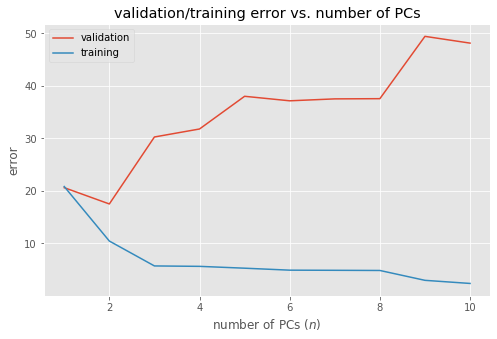

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

m = 500   # total number of data points 
D = 10    # length of raw feature vector 

Z, y = GetFeaturesLabels(m, D)   # read in m data points from the house sales database 
        
# Use these features for PCA 
Z_pca = Z[:480,:]  # read out feature vectors of first 480 data points 

# Use these features and labels for linear regression (with transformed features)
Z_reg = Z[480:,:]    # Read out feature vectors of last 20 data points 
y_reg = y[480:,:]    # Read out labels of last 20 data points 

# Datasets which will be preprocessed and used with linear regression
Z_train, Z_val, y_train, y_val = train_test_split(Z_reg, y_reg, test_size=0.2, random_state=42)

err_train = np.zeros(D)    # Array for storing training errors of the linear regression model
err_val = np.zeros(D)     # Array for storing validation errors of the linear regression model

for n in range(1, D+1):
    # Create the PCA object and fit
    # transform long feature vectors (length D) to short ones (length n)
    ### STUDENT TASK ### 
    # -Fit a PCA model with n components
    # -Compress Z_train and Z_val using PCA 
    # -Use the compressed features to fit a linear model
    # -Calculate the training and validation errors of the 
    ### BEGIN SOLUTION
    pca = PCA(n_components=n)
    pca.fit(Z_pca)
    X_train = pca.transform(Z_train)
    X_val   = pca.transform(Z_val)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)
    err_train[n-1] = np.mean((y_train - y_pred_train)**2)  # compute training error 
    err_val[n-1] = np.mean((y_val - y_pred_val)**2)   # compute validation error 
    ### END SOLUTION

# Print validation errors for quiz purposes
print(f"Validation errors: \n {err_val}")
    
# Plot the training and validation errors
plt.figure(figsize=(8,5))
plt.plot(range(1, D+1), err_val, label="validation")
plt.plot(range(1, D+1), err_train, label="training")
plt.xlabel('number of PCs ($n$)')
plt.ylabel(r'error')
plt.legend()
plt.title('validation/training error vs. number of PCs')
plt.show()

In [14]:
# Perform sanity checks on the outputs
assert err_train[0] >= err_train[4], "values in err_train wrong"
assert err_val[1] <= err_val[4], "values in err_val wrong"

### BEGIN HIDDEN TESTS
t_err_val = np.zeros(D)     # this numpy array has to be used to store the validation 
t_err_train = np.zeros(D)   #  errors of linear regression when combined with PCA with n=1,2,..,D

for n in range(1, D+1):
    t_pca = PCA(n_components = n)
    t_pca.fit(Z_pca)
    t_X_train = t_pca.transform(Z_train)
    t_X_val   = t_pca.transform(Z_val)
    t_model = LinearRegression(fit_intercept=True)
    t_model.fit(t_X_train,y_train)
    t_y_pred_train = t_model.predict(t_X_train)
    t_y_pred_val = t_model.predict(t_X_val)
    t_err_train[n-1] = np.mean((y_train - t_y_pred_train)**2)  # compute training error 
    t_err_val[n - 1] = np.mean((y_val - t_y_pred_val)**2)   # compute validation error 

np.testing.assert_allclose(t_err_train.reshape(1,-1), err_train.reshape(1,-1), rtol=0.001, err_msg='err_pca has wrong value')
np.testing.assert_allclose(t_err_val.reshape(1,-1), err_val.reshape(1,-1), rtol=0.001, err_msg='err_pca has wrong value')
### END HIDDEN TESTS

print('Sanity checks passed!')

Sanity checks passed!


If the task is correctly solved, one should see that while the training error decreases monotonically with an increasing number of components, the validation error does not. Rather, there is an optimum number of components to be used. This is similar to what was observed in round 4, where we searched for the optimum number of features to be used for predicting the grayscale values of pixels. The difference is that in the task above we use PCA for each $n$ to obtain the $n$ features that capture as much of the variance of the original data as possible (for $n$ features).

While this technique seems very convenient based on this example, there are some caveats that are good to be aware of. The first, and perhaps most important in an ML setting, is that **even though the PCA features maximize the explained variance in the data $\mathbf{Z}$ they do not necessarily contain the most infomation w.r.t. to the target $\mathbf{y}$**. In fact, PCA pre-preprocessing might even worsen outcomes by losing information that is relevant w.r.t. the target variable.

The second major caveat is that PCA pre-processing might result in features that are difficult to interpret, which reduces the ability to infer relationships between real-life features and the target. This is perhaps less important in the realm of machine learning where interpretibility is not always a priority, but it is nevertheless good to be aware of this.

Overall, Pre-processing with PCA can be useful in many situations, but due to its caveats it is best not to use it indiscriminately. It is better to evaluate its use on a case-by-case basis, and apply it in your final model if its use results in a better predictive capability.

## The Final Quiz

<a id='QuestionR6_1'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.1. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> Dimensionality reduction helps to avoid overfitting.</li>
  <li> Dimensionality reduction can only be used for labeled data points.</li>
  <li> Dimensionality reduction can only be used for vectors having no more than $100$ entries.</li>
  <li> Dimensionality reduction is a classification method.</li>
</ol> 

</div>

In [16]:
# answer_R6_Q1  = ...
### BEGIN SOLUTION
answer_R6_Q1 = 1
### END SOLUTION

In [17]:
# this cell is for tests
assert answer_R6_Q1 in [1,2,3,4], '"answer_R6_Q1" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')

### BEGIN HIDDEN TESTS
assert answer_R6_Q1 in [1,2,3,4], '"answer_R6_Q1" Value should be an integer between 1 and 4.'
assert answer_R6_Q1 == 1, ' "answer_R6_Q1" Correct answer is 1.'
### END HIDDEN TESTS

Sanity check tests passed!


<a id='QuestionR6_2'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.1. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> In general, dimensionality reduction increases the computational requirements of fitting a model on the data.</li>
  <li> No information in the original data is lost when performing dimensionality reduction via PCA.</li>
  <li> In general, dimensionality reduction reduces the computational requirements of fitting a model on the data.</li>
  <li> PCA cannot be used for data visualization.</li>
</ol> 

</div>

In [18]:
# answer_R6_Q2  = ...
### BEGIN SOLUTION
answer_R6_Q2 = 3
### END SOLUTION

In [19]:
# this cell is for tests
assert answer_R6_Q2 in [1,2,3,4], '"answer_R6_Q2" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')

### BEGIN HIDDEN TESTS
assert answer_R6_Q2 == 3, ' "answer_R6_Q2" Correct answer is 3.'
### END HIDDEN TESTS

Sanity check tests passed!


<a id='QuestionR6_3'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.3. </p>

 <p>Consider using PCA as preprocessing to transform long raw feature vectors $\mathbf{z} \in \mathbb{R}^{D}$ to  shorter feature vectors $\mathbf{x} \in \mathbb{R}^{n}$ that are then used in linear regression. What is the effect of using a larger number $n$ of principal components in PCA?</p>

<ol>
  <li> The training error obtained from linear regression will decrease.</li>
  <li> The training error obtained from linear regression will increase.</li>
</ol> 

</div>

In [20]:
# answer_R6_Q3  = ...
### BEGIN SOLUTION
answer_R6_Q3 = 1
### END SOLUTION

In [21]:
# this cell is for tests
assert answer_R6_Q3 in [1,2], '"answer_R6_Q3" Value should be an integer between 1 and 2.'
print('Sanity check tests passed!')

### BEGIN HIDDEN TESTS
assert answer_R6_Q3 == 1, ' "answer_R6_Q3" Correct answer is 1.'
### END HIDDEN TESTS

Sanity check tests passed!


<a id='QuestionR6_3'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.4. </p>

 <p>Consider using PCA as preprocessing to transform long raw feature vectors $\mathbf{z} \in \mathbb{R}^{D}$ to  shorter feature vectors $\mathbf{x} \in \mathbb{R}^{n}$ that are then used in linear regression. Will this always result in better performance on new data for a linear regression model?</p>

<ol>
  <li> No.</li>
  <li> Yes.</li>
</ol> 

</div>

In [22]:
# answer_R6_Q4  = ...
### BEGIN SOLUTION
answer_R6_Q4 = 1
### END SOLUTION

In [23]:
# this cell is for tests
assert answer_R6_Q4 in [1,2], '"answer_R6_Q4" Value should be an integer between 1 and 2.'
print('Sanity check tests passed!')

### BEGIN HIDDEN TESTS
assert answer_R6_Q4 == 1, ' "answer_R6_Q4" Correct answer is 1.'
### END HIDDEN TESTS

Sanity check tests passed!
